In [1]:
import numpy as np
import pyfftw

from math import pi
import math

import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from scipy.interpolate import griddata
from scipy.interpolate import interp1d
import scipy.signal
from numpy import linalg as LA
#from matplotlib.mlab import griddata
params = {'legend.fontsize': 15,
          'legend.loc':'best',
          'figure.figsize': (14,5),
          'lines.markerfacecolor':'none',
         'axes.labelsize': 17,
         'axes.titlesize': 17,
         'xtick.labelsize':15,
         'ytick.labelsize':15,
         'grid.alpha':0.6}
pylab.rcParams.update(params)
#%matplotlib notebook
%matplotlib inline

from tqdm import tqdm
import sys

## Define directories

In [2]:
vtu_dir = '../vtu/'
meshfile_dir = '../../geo/'

## Import VTK files

In [3]:
import vtkreader as reader

In [4]:
start = 100.00 #50
end = 150.00   #199.98
dt = 0.02

time = np.arange(start, end, dt)
filename = []
for i in range(len(time)):
    filename.append(vtu_dir+"{:.2f}".format(time[i])+'.vtu')

x,y = reader.load_coordinate(filename[0])


p = np.zeros([len(time),len(x)])    # only p is interested here
u = np.zeros([len(time),len(x)])    # only p is interested here
v = np.zeros([len(time),len(x)])    # only p is interested here
rho = np.zeros([len(time),len(x)])    # only p is interested here



for i in tqdm(range(len(time))):
    p[i],u[i],v[i],rho[i] = reader.load_vtkFile(filename[i])
    if time[i] == end:
        print('loading data: done!')

print(p.shape)

100%|██████████| 2500/2500 [09:24<00:00,  4.43it/s]

(2500, 448390)


## Calculate Fluctuation Values

In [5]:
import basis

In [6]:
dp,dpmean,dptuda = basis.fluc_pressure(p,time)
du,dumean,dutuda = basis.fluc_varibles(u,time,0.3*1.0)
dv,dvmean,dvtuda = basis.fluc_varibles(v,time,0.0)
drho,drhomean,drhotuda = basis.fluc_varibles(rho,time,1.0)

In [7]:
print(drhotuda.shape)

(2500, 448390)


## SVD Singular-Valued Decomposition

In [8]:
def SVD(var,time):
    ## check the shape of the input value
    if var.shape[0] == len(time):
        Y = var.T
    elif var.shape[1] == len(time):
        Y = var
    else:
        exit()
        
    # calculate manupulate matrix A
    A = np.dot(Y.T,Y)
    
    # compute the eigenvectors and engenvalues of A
    w, v = LA.eig(A)    # w is eigenvalue, v[:,i] is normaöized eigenvector of w[i]
    
    #compute sig = sqrt(w)
    sig = np.zeros([len(w),len(w)])
    sig_plot = np.zeros(len(w))
    ## check routine
    for i in w:
        if i < 0:
            print('Warning!: eignevalue is smaller than 0: eig = ' + str(i))
            if abs(i) < 10e-5:
                print('Warning!: eignevalue is significantly close to zero, take absolute value!')
            else:
                print('Error!: Check with eigenvalue, programme exits...')
                return 0,0,0
    
    for i in range(len(w)):
        sig[i,i] = 1/np.sqrt(abs(w[i]))
        sig_plot[i] = np.sqrt(abs(w[i]))
        
    # calculate POD MODEs U = Y*W*sig
    U = np.dot(np.dot(Y,v),sig)
    
    # calculate POD coeeficiemnt matrix
    coeff = np.dot(U.T,Y)    # x shape: first row:x1 last row:xN; first colomn:t1 last colomn:tN
    
    return U,coeff,sig_plot

## POD routine

In [ ]:
U,coeff,sig_plot = tqdm(SVD(dptuda,time))

In [ ]:
bb = np.dot(U.T,U)
bb[10,10]

In [ ]:
#assume t = 0, check routine
recover = np.zeros([U.shape[1],time.shape[0]])
#for i in range(len(time)):
recover = np.matmul(U,coeff)

In [ ]:
sig_sum = np.sum(sig_plot)
plt.bar(np.arange(len(sig_plot)),sig_plot/sig_sum)
plt.xlim([-2,50])
plt.yscale('log')
plt.xlabel('POD Modes')
plt.ylabel('SVD singular vaule $\sigma_i/\sum_i^N\sigma_i$')

## SPOD routine

In [8]:
def SPOD(var,NFFT,overlap,FreqofInterest):
    ## use the notation from Schimit & Colonius 2020
    
    def Input_routine(var,NFFT,overlap):
        print('Input parameters:\nNFFT = '+str(NFFT)+'\noverlap = '+str(overlap)+'\n')
        ## check the shape of the input value
        if var.shape[0] < var.shape[1]:
            Y = var.T
            return Y
        elif var.shape[1] < var.shape[0]:
            Y = var
            return Y
        else:
            ValueError('No mate, input data shape is not alright, it is not gonna work')
            return 0


    def Creat_blocks(var,NFFT,overlap,time):
        print('-------------------------------------------------')
        print('Divide the varible into blocks using \'NFFT\' and \'overlap\' parameters')
        print('-------------------------------------------------')
        Nblocks = int( (len(time)-NFFT) // (NFFT*(1-overlap)) + 1 )
        print('Number of blocks: '+str(Nblocks))
        blocks = np.zeros([var.shape[0],NFFT,Nblocks],dtype = 'complex_')   # blocks.shape = npts,nfft,blockid
        for i in range(Nblocks):
            if i == 0:
                blocks[:,:,i] = var[:,0:NFFT]
            else:
                blocks[:,:,i] = var[:,int(i*NFFT-i*NFFT*overlap):int((i+1)*NFFT-i*NFFT*overlap)]
        print('block shape: '+str(blocks.shape))
        print('-------------------------------------------------')
        return blocks

    
    def block_DFT(blocks):
        print('-------------------------------------------------')
        print('Do DFT to each block')
        print('-------------------------------------------------')
        def hamming_window(N):
            '''
                Standard Hamming window of length N
            '''
            x = np.arange(0,N,1)
            window = (0.54 - 0.46 * np.cos(2 * np.pi * x / (N-1)) ).T
            return window

        #blockHat = np.zeros([blocks.shape[0],blocks.shape[1],blocks.shape[2]],dtype = 'complex_')

        window = hamming_window(blocks.shape[1])
        print('Compeleted blocks: ')
        for i in tqdm(range(blocks.shape[2])):   #block.shape[2] == Nblocks
            #blockHat[:,:,i] = pyfftw.interfaces.numpy_fft.fftn(blocks[:,:,i],axes=1)*window  #this could be faster
            blocks[:,:,i] = np.fft.fft(blocks[:,:,i]*window ,axis=1)  #overwrite
        print('blockHat shape: '+str(blocks.shape))
        print('-------------------------------------------------')
        return blocks
    
    
    def creat_freq_blocks(blockHat,FreqofInterest):
        print('-------------------------------------------------')
        print('Assemble the data matrix in frequency domain: Qhat.shape = [npts,Nblocks,Nfrequencies]')
        print('-------------------------------------------------')
        Qhat = np.zeros([blockHat.shape[0],blockHat.shape[2],FreqofInterest],dtype = 'complex_')  # for memory problem FreqofInterest << blockHat.shape[1]
        for i in range(FreqofInterest):
            for j in range(blockHat.shape[2]):
                Qhat[:,j,i] = blockHat[:,i,j]
        print('Qhat block shape: '+str(Qhat.shape))
        print('-------------------------------------------------') 
        return Qhat
    
    
    def SPOD_SVD(Qhat):
        print('-------------------------------------------------')
        print('Compute inner production to each block')
        print('-------------------------------------------------')

        print('Compeleted frequencies: ')

        A = np.zeros([Qhat.shape[1],Qhat.shape[1],Qhat.shape[2]],dtype = 'complex_')
        #Weight = BuildWieghtMatrix(TypeofWeight,Nvars,shape = Qhat.shape[0])
        for i in tqdm(range(Qhat.shape[2])):
            """
                a = blockHat[:,:,i]
                b = np.matmul(a.T,a)
            """
            #A[:,:,i] = np.dot(np.dot(Qhat[:,:,i].conj().T,Weight) , Qhat[:,:,i])/(Qhat.shape[1] - 1)    #using matmul could be super slow
            A[:,:,i] = np.dot(Qhat[:,:,i].conj().T , Qhat[:,:,i])#/(Qhat.shape[1] - 1)    #using matmul could be super slow
        print(A.shape)
        print('-------------------------------------------------')
    
    
        print('-------------------------------------------------')
        print('Compute the eigenvectors and engenvalues of A')
        print('-------------------------------------------------')

        w = np.zeros([A.shape[1],A.shape[2]],dtype='complex_')
        v = np.zeros([A.shape[1],A.shape[1],A.shape[2]],dtype='complex_')
        for i in range(A.shape[2]):
            w[:,i], v[:,:,i] = LA.eig(A[:,:,i])    # w is eigenvalue, v[:,:,i] is normaöized eigenvector of w[:,i]
        print('-------------------------------------------------')
        
        
        ## check routine
        for j in range(w.shape[1]):
            for i in w[:,j]:
                if i < 0:
                    print('Warning!: eignevalue is smaller than 0: eig = ' + str(i))
                    if abs(i) < 10e-5:
                        print('Warning!: eignevalue is significantly close to zero, take absolute value!')
                        
                    else:
                        print('Error!: Check with eigenvalue, programme exits...')
                        return 0,0,0
    
    
    
        print('-------------------------------------------------')
        print('Formulate eq9 in Andre\'s paper (performing the SVD)')
        print('-------------------------------------------------')


        sig = np.zeros([w.shape[0],w.shape[0],w.shape[1]],dtype='complex_')
        for i in range(w.shape[1]):
            for j in range(w.shape[0]):
                if w[j,i] == 0:
                    sig[j,j,i] = 0
                else:
                    sig[j,j,i] = 1/np.sqrt(w[j,i])

        Phi = np.zeros([Qhat.shape[0],Qhat.shape[1],Qhat.shape[2]],dtype='complex_')
        for i in range(A.shape[2]):
            Phi[:,:,i] = np.dot(np.dot(Qhat[:,:,i],v[:,:,i]),sig[:,:,i])


        print('-------------------Done!------------------------')
        return Phi,w
        
    
    var = Input_routine(var,NFFT,overlap)
    overwrite_matrix = Creat_blocks(var,NFFT,overlap,time)  #here returns blocks
    overwrite_matrix = block_DFT(overwrite_matrix)  #here returns blockHat
    overwrite_matrix = creat_freq_blocks(overwrite_matrix,FreqofInterest) #here returns QHat
    Phi,w = SPOD_SVD(overwrite_matrix)
    
        
    return Phi,w

In [9]:
def BuildWieghtMatrix(TypeofWeight,Nvars,shape):
    if TypeofWeight == 1:
        weight = np.eye(Nvars*shape)
    return Weight

In [10]:
## assemble input matrix
flucU = np.concatenate((dutuda,dvtuda),axis=1)

In [11]:
var = dptuda
NFFT = 596
overlap = 0.75
FreqofInterest = 5
Phi,w = SPOD(var,NFFT,overlap,FreqofInterest)

Input parameters:
NFFT = 596
overlap = 0.75

-------------------------------------------------
Divide the varible into blocks using 'NFFT' and 'overlap' parameters
-------------------------------------------------
Number of blocks: 13
block shape: (448390, 596, 13)
-------------------------------------------------
-------------------------------------------------
Do DFT to each block
-------------------------------------------------
Compeleted blocks: 


100%|██████████| 13/13 [03:55<00:00, 18.12s/it]


blockHat shape: (448390, 596, 13)
-------------------------------------------------
-------------------------------------------------
Assemble the data matrix in frequency domain: Qhat.shape = [npts,Nblocks,Nfrequencies]
-------------------------------------------------
Qhat block shape: (448390, 13, 5)
-------------------------------------------------
-------------------------------------------------
Compute inner production to each block
-------------------------------------------------
Compeleted frequencies: 


100%|██████████| 5/5 [00:00<00:00,  8.44it/s]


(13, 13, 5)
-------------------------------------------------
-------------------------------------------------
Compute the eigenvectors and engenvalues of A
-------------------------------------------------
-------------------------------------------------
-------------------------------------------------
Formulate eq9 in Andre's paper (performing the SVD)
-------------------------------------------------
-------------------Done!------------------------


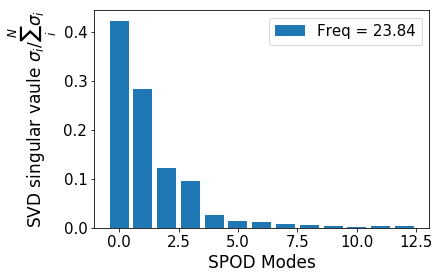

In [12]:
freq_index = 2
freq = freq_index*NFFT/(0.02*u.shape[0])  #f = m*NFFT/T
sig_plot = np.sqrt(w[:,freq_index])
sigg_sum = np.sum(sig_plot.real)
    
plt.bar(np.arange(sig_plot.shape[0]),sig_plot.real/sigg_sum,label='Freq = '+str(freq))
#plt.xlim([-2,50])
#plt.yscale('log')
plt.xlabel('SPOD Modes')
plt.ylabel('SVD singular vaule $\sigma_i/\sum_i^N\sigma_i$')
plt.legend()

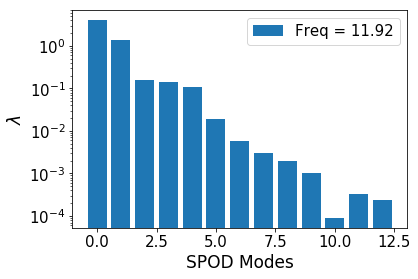

In [13]:
freq_index = 1
SPOD_eig = w[:,freq_index]    
freq = freq_index*NFFT/(0.02*u.shape[0])  #f = m*NFFT/T
plt.bar(np.arange(SPOD_eig.shape[0]),SPOD_eig.real,label='Freq = '+str(freq))
#plt.xlim([-2,50])
plt.yscale('log')
plt.xlabel('SPOD Modes')
plt.ylabel('$\lambda$')
plt.legend()

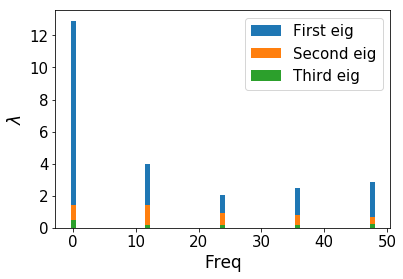

In [14]:
freq_index = np.arange(w.shape[1])
 
freq = freq_index*NFFT/(0.02*u.shape[0])  #f = m*NFFT/T
plt.bar(freq,w[0,:].real,label='First eig')
plt.bar(freq,w[1,:].real,label='Second eig')
plt.bar(freq,w[2,:].real,label='Third eig')

plt.xlabel('Freq')
plt.ylabel('$\lambda$')
plt.legend()

In [15]:
aa = np.dot(Phi[:,:,2].conj().T,Phi[:,:,2])
print(aa.trace())

(13.000000000007923+0j)


In [16]:
dptuda.shape

(2500, 448390)

## Write to vtk file

In [59]:
import vtkwriter as writer
U = Phi[:,:,0].real

In [60]:
length = 5
input_time = 0  
append_data = np.zeros([U.shape[0],length])
append_data[:,0:length] = U[:,0:length]
#append_data[:,length] = dp[input_time,:]
#append_data[:,length+1] = recover[:,input_time]

append_data_name = []
for i in range(length):
    append_data_name.append('mode_'+str(i))
print(append_data.shape)
  
#append_data_name.append('dp')
#append_data_name.append('recovered')

length = append_data.shape[1]
input_file_name = '../vtu/100.00.vtu'

writer.yzywriter(input_file_name,append_data,append_data_name,length)

(448390, 5)
Writing...
Done!


In [40]:
## check the differency between recover field and original
df = LA.norm(dptuda[input_time,:] - recover[:,input_time],np.inf)
print(df)

NameError: name 'recover' is not defined